In [11]:
import pandas as pd
import torch.nn as nn
import torch

In [13]:
df_reviews = pd.read_csv("Amazon-Product-Reviews - Amazon Product Review(1).csv")[["review_body", "sentiment"]]
df_reviews = df_reviews.head(10000)
df_reviews

,review_body,sentiment
0,Great love it,1
1,Lots of ads<br />Slow processing speed<br />Oc...,0
2,Excellent unit. The versatility of this table...,1
3,I bought this on Amazon Prime so I ended up bu...,1
4,All Amazon products continue to meet my expect...,1
...,...,...
9995,quick and clear very happy,1
9996,Love It so Fun to Use The Books Are awesome,1
9997,Better than I expected! I have one that is a c...,1
9998,"so far, it has gone way beyond my expectations.",1


In [15]:
class Vocab:
    """ 用于存储单词的词典类 """
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add(self, word):
        """ 添加单词 """
        if word not in self.idx2word:
            self.word2idx[word] = len(self.idx2word)
            self.idx2word.append(word)

    def __len__(self):
        """ 返回已存储的单词个数 """
        return len(self.idx2word)

In [17]:
class Embedding(nn.Module):
    def __init__(self, one_hot_size, vector_size):
        super().__init__()
        self.one_hot_size = one_hot_size
        self.fc = nn.Linear(one_hot_size, vector_size) # Fake embedding

    def forward(self, token_tensor):
        
        for token in token_tensor:
            init_one_hot = torch.zeros(1, self.one_hot_size)
            init_one_hot[0][token] = 1
            return self.fc(init_one_hot).squeeze()

In [91]:
reviews = df_reviews["review_body"]
reviews = reviews.dropna()
type(reviews)


filt = ["(", ")", "<", ">", ".", "...", ",", "!", "!!", "?", "/", "\\", "[", "]", "#", "&", "*" ] # ...
vocab = Vocab()
for word in list(reviews.values):
    word = word.replace("<br />", " ")
    lst = word.strip().split(" ")
    for single_word in lst:
        if single_word not in filt:
            vocab.add(single_word.strip()) 

In [28]:
class Word2Vec(nn.Module):
    """ 词向量模型 """
    def __init__(self, word_list, vector_size):
        super().__init__()
        self.word_list = word_list
        self.vector_size = vector_size
        self.embeddings = nn.Embedding(len(word_list), vector_size)
        self.fc = nn.Linear(vector_size, len(word_list))

    def forward(self, x):
        embedded = self.embeddings(x)
        return self.fc(embedded)

model = Word2Vec(vocab, 16)

In [29]:

def skipgram_data(words, window_size: int):
    """ 创建 Skip-Gram模型训练数据 """
    target_data = []
    context_data = []
    for i, target_word in enumerate(words):
        for j in range(max(0, i-window_size), min(len(words), i+window_size+1)):
            if j != i:
                context_word = words[j]
                target_data.append(vocab.word2idx.get(target_word))
                context_data.append(vocab.word2idx.get(context_word))
    return target_data, context_data
              
line = vocab.idx2word

In [30]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

target_data, context_data = skipgram_data(line, 1)

dataset = TensorDataset(torch.tensor(target_data), torch.tensor(context_data))

dtloader = DataLoader(dataset, batch_size = 256, shuffle=True)

In [43]:
def train_model(model, dataloader, loss_func, optimizer):
    """ 哞 """
    model.train()
    total_loss = 0
    for target, context in dataloader:
        context_hat = model(target)
        loss = loss_func(context_hat, context)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

In [45]:
model = Word2Vec(vocab, 16)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = dtloader

In [234]:
n_epoch = 500

train_loss = []
for i in range(n_epoch):
    loss = train_model(model, dataloader, loss_func, optimizer)
    train_loss.append(loss)
    print(f"Epoch {i+1} loss: {round(loss, 4)}")

Epoch 1 loss: 1.6592
Epoch 2 loss: 1.6344
Epoch 3 loss: 1.6094
Epoch 4 loss: 1.5857
Epoch 5 loss: 1.5623
Epoch 6 loss: 1.5403
Epoch 7 loss: 1.5186
Epoch 8 loss: 1.4972
Epoch 9 loss: 1.4772
Epoch 10 loss: 1.4575
Epoch 11 loss: 1.4391
Epoch 12 loss: 1.4205
Epoch 13 loss: 1.4024
Epoch 14 loss: 1.385
Epoch 15 loss: 1.3683
Epoch 16 loss: 1.3527
Epoch 17 loss: 1.337
Epoch 18 loss: 1.3221
Epoch 19 loss: 1.3077
Epoch 20 loss: 1.2937
Epoch 21 loss: 1.2802
Epoch 22 loss: 1.267
Epoch 23 loss: 1.2545
Epoch 24 loss: 1.2425
Epoch 25 loss: 1.2309
Epoch 26 loss: 1.2194
Epoch 27 loss: 1.2084
Epoch 28 loss: 1.1972
Epoch 29 loss: 1.1875
Epoch 30 loss: 1.1777
Epoch 31 loss: 1.1684
Epoch 32 loss: 1.159
Epoch 33 loss: 1.1502
Epoch 34 loss: 1.1415
Epoch 35 loss: 1.1332
Epoch 36 loss: 1.1255
Epoch 37 loss: 1.1177
Epoch 38 loss: 1.1104
Epoch 39 loss: 1.1031
Epoch 40 loss: 1.0961
Epoch 41 loss: 1.0896
Epoch 42 loss: 1.0831
Epoch 43 loss: 1.0769
Epoch 44 loss: 1.0709
Epoch 45 loss: 1.0654
Epoch 46 loss: 1.0596
E

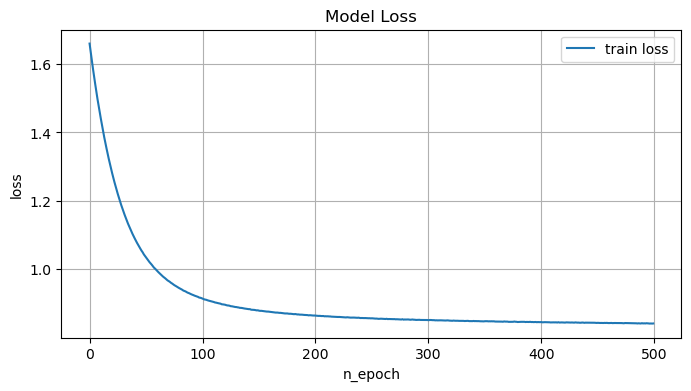

In [239]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_loss, label="train loss")
plt.title("Model Loss")
plt.xlabel("n_epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

In [241]:
line = vocab.word2idx

In [243]:
line

{'Great': 0,
 'love': 1,
 'it': 2,
 'Lots': 3,
 'of': 4,
 'ads': 5,
 'Slow': 6,
 'processing': 7,
 'speed': 8,
 'Occasionally': 9,
 'shuts': 10,
 'down': 11,
 'apps': 12,
 'WIFI': 13,
 'keeps': 14,
 'having': 15,
 'authentication': 16,
 'issues': 17,
 '': 18,
 'Was': 19,
 'cheap': 20,
 'for': 21,
 'a': 22,
 'tablet': 23,
 'and': 24,
 'now': 25,
 'i': 26,
 'know': 27,
 'why.': 28,
 'Excellent': 29,
 'unit.': 30,
 'The': 31,
 'versatility': 32,
 'this': 33,
 'tablet,': 34,
 'besides': 35,
 'being': 36,
 'competitively': 37,
 'priced': 38,
 'is': 39,
 'solution': 40,
 'to': 41,
 'the': 42,
 'elderly.': 43,
 'Poor': 44,
 'eyesight': 45,
 'physical': 46,
 'disabilities': 47,
 'associated': 48,
 'with': 49,
 'age': 50,
 'using': 51,
 'supporting': 52,
 'add': 53,
 'on': 54,
 'features': 55,
 'allows': 56,
 'user': 57,
 'stay': 58,
 'in': 59,
 'touch': 60,
 'our': 61,
 'changing': 62,
 'world.': 63,
 'A': 64,
 'realistic': 65,
 'keyboard': 66,
 'that': 67,
 'you': 68,
 'can': 69,
 'see': 70,


In [272]:
def cos_sim(word1, word2):
    """ 计算余弦相似度 """
    v1 = model.embeddings(torch.tensor(line[word1]))
    v2 = model.embeddings(torch.tensor(line[word2]))
    return (word1, word2), v1@v2/(torch.norm(v1)*torch.norm(v2))

In [274]:
print(cos_sim("Great", "amazing"),
      cos_sim("Great", "bad"),
      cos_sim("slow", "bad"),
      cos_sim("love", "hate"), 
      cos_sim("this", "it"), 
      cos_sim("nice", "great"), sep = "\n",)

(('Great', 'amazing'), tensor(-0.0387, grad_fn=<DivBackward0>))
(('Great', 'bad'), tensor(-0.5521, grad_fn=<DivBackward0>))
(('slow', 'bad'), tensor(0.1197, grad_fn=<DivBackward0>))
(('love', 'hate'), tensor(-0.1758, grad_fn=<DivBackward0>))
(('this', 'it'), tensor(0.0507, grad_fn=<DivBackward0>))
(('nice', 'great'), tensor(0.3738, grad_fn=<DivBackward0>))
